In [2]:
library(data.table)
library(stringr)
library(pheatmap)
library(ape)
library(ggplot2)
library(Rtsne)
library(sva)
library(VennDiagram)
library(readxl)
library(energy)
library(MASS)
library(quantreg)
library(limma)
library(Glimma)
library(edgeR)
library(RColorBrewer)
library(minerva)
library(dbscan)
library(amap)
library(NbClust)
library(apeglm)
library(gplots)
library(colorspace)
library(dendextend)
library(data.table)
library(topGO)
library(treemap)
library(ggbiplot)
library(factoextra)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(parallel)
library(randomForest)
library(e1071)
library(adabag)
library(ggpubr)
library(dbscan)
library(viridis) 

Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.
Loading required package: genefilter
Loading required package: BiocParallel
Loading required package: grid
Loading required package: futile.logger

Attaching package: ‘futile.logger’

The following object is masked from ‘package:mgcv’:

    scat


Attaching package: ‘VennDiagram’

The following object is masked from ‘package:ape’:

    rotate


Attaching package: ‘MASS’

The following object is masked from ‘package:genefilter’:

    area

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


---------------------
Welcome to dendextend version 1.13.4
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github pag

In [3]:
color_AD <- "#FF3300"
color_ND <- "blue"
color_CHC <- "#FFCC00"
font_size <- 10
font_size_add <- 2

circle_size_1 <- 2
circle_size_2 <- 3

In [4]:
setwd("~/ownCloud/Meng/")

In [5]:
cell_type_matrix <- read.table("R_workstation/100_plus_proteomic_cell_type_enrichment/EWCE_celltype_v2.tsv",
                               header =TRUE,
                               stringsAsFactors=F, sep = "\t")

In [6]:
protein_info <- read.table("100_plus_results/Protein basic info.tsv", 
                           sep = "\t", header =TRUE, stringsAsFactors=F)

In [7]:
High_quality_protein_intensity_matrix <- read.table('R_workstation/100_plus_proteomic_DATA/High_quality_protein_intensity_matrix.tsv', header =TRUE,
                                                    stringsAsFactors=F, sep = "\t")
dim(High_quality_protein_intensity_matrix)

[1] 3448  191

In [8]:
load("100_plus_project/Metadata/metadata_clean_update20211215.Rdata")
#metadata_clean
metadata <- metadata_clean

colnames(metadata)

names_sample <- as.array(colnames(High_quality_protein_intensity_matrix)[2:ncol(High_quality_protein_intensity_matrix)])
names_sample <- as.vector(apply(names_sample, 1, function(names){return (str_sub(names, 11))}))

filenames_map_index <- integer(length(names_sample))
for (i in 1:length(names_sample)){
    if ((names_sample[i] %in% metadata[,"Mass-Spec filenames (1)"]) | 
        (names_sample[i] %in% metadata[,"Mass-Spec filenames (2)"]))
        filenames_map_index[i] <- ifelse(length(which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))==0,
                                     which(metadata[,"Mass-Spec filenames (2)"] == names_sample[i]), 
                                     which(metadata[,"Mass-Spec filenames (1)"] == names_sample[i]))
    else
        print("ERROR, file name not in metadata!")
}

metadata <- metadata[filenames_map_index, ][c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", 
                                              "Abeta", "APOE")]
colnames(metadata) <- c("nbb", "autopsy", "sex", "age", "weight", "GROUP", "pmd", "braak", "amyloid", "apoe")
metadata$filenames <- names_sample

metadata$sex[(metadata$sex=='F') | (metadata$sex=='f')] <- "F"
metadata$sex[(metadata$sex=='M') | (metadata$sex=='m')] <- "M"
metadata$braak <- as.numeric(metadata$braak)
metadata$age <- as.numeric(metadata$age)


index_AD <- which(metadata$GROUP == "AD")
index_CHC <- which(metadata$GROUP == "CHC")
index_ND <- which(metadata$GROUP == "ND")
num_AD <- length(index_AD)
num_CHC <- length(index_CHC)
num_ND <- length(index_ND)

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$braak))),]$braak <- median(metadata[index_ND,]$braak, na.rm = TRUE)

metadata$fBraak <- metadata$braak
metadata[which(metadata$braak == 0), ]$fBraak <- 1

metadata$cBraak <- as.numeric(lapply(metadata$braak, function(braak){if (braak==0 | braak==1 | braak==2)
                                                                return(1)
                                                          if (braak==3 | braak==4)
                                                                return(2)
                                                          if (braak==5 | braak==6)
                                                                return(3)}))



metadata[which((metadata$GROUP=="AD") & (is.na(metadata$amyloid))),]$amyloid <- 3
metadata[which((metadata$GROUP=="ND") & (is.na(metadata$amyloid))),]$amyloid <- 1

get_mod <- function(apoe){
    apoe_count <- as.matrix(table(apoe))
    return (rownames(apoe_count)[which.max(apoe_count)])
}

metadata[which((metadata$GROUP=="ND") & (is.na(metadata$apoe))),]$apoe <- get_mod(metadata[index_ND,]$apoe)

metadata$apoe_OR <- as.numeric(metadata$apoe)

metadata[which(metadata$apoe %in% c(22)),]$apoe_OR <- 0.24
metadata[which(metadata$apoe %in% c(23, 32)),]$apoe_OR <- 0.5
metadata[which(metadata$apoe %in% c(33)),]$apoe_OR <- 1.0
metadata[which(metadata$apoe %in% c(24, 42)),]$apoe_OR <- 3.2
metadata[which(metadata$apoe %in% c(34, 43)),]$apoe_OR <- 5.5
metadata[which(metadata$apoe %in% c(44)),]$apoe_OR <- 20.6

convert_time_2_numeric <- function(pmd){
    if (is.na(pmd))
        return (NA)
    else
        return (as.numeric(str_sub(pmd, start=1, end=2))+as.numeric(str_sub(pmd, 4))/60)
}

metadata$pmd_numeric <- apply(metadata["pmd"], 1, convert_time_2_numeric)
metadata[which(is.na(metadata$pmd_numeric)),]$pmd_numeric <- median(metadata$pmd_numeric, na.rm = TRUE)


MMSE_data <- read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData_manualaddMMSE.xlsx",sheet=1,col_names=TRUE, na="NA")
#MMSE_data
MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
#nrow(MMSE_data)

metadata$MMSE <- rep(NA, nrow(metadata))

for (i in 1:nrow(metadata)){
    if (metadata[i,]$GROUP == "CHC"){
        metadata[i,]$MMSE <- MMSE_data[which(MMSE_data$NBB == metadata[i,]$nbb),]$MMSE_LV
    }
}

metadata$MMSE <- as.numeric(metadata$MMSE)
#metadata$amyloid <- factor(metadata$amyloid, levels = c("O", "A", "B", "C"))
#
#metadata$Abeta <- 0
#metadata[metadata$amyloid == "A", ]$Abeta <- 1
#metadata[metadata$amyloid == "B", ]$Abeta <- 2
#metadata[metadata$amyloid == "C", ]$Abeta <- 3

metadata$age_level <- NA
metadata[metadata$age<=70,]$age_level <- 1
metadata[(metadata$age>70)&(metadata$age<=80),]$age_level <- 1
metadata[(metadata$age>80)&(metadata$age<=90),]$age_level <- 2
metadata[(metadata$age>90)&(metadata$age<100),]$age_level <-2
metadata[(metadata$age>=100),]$age_level <- 3

metadata$MMSE_level <- NA
metadata[which(metadata$MMSE >= 26),]$MMSE_level <- 2
metadata[which((metadata$MMSE >= 23) & (metadata$MMSE < 26)),]$MMSE_level <- 1
metadata[which(metadata$MMSE < 23),]$MMSE_level <- 1

[1] "nbb"                                 "autopsy"                            
 [3] "sampleprepRandomization (4 batches)" "zmRandomization (10 batches)"       
 [5] "Autopsy_nr"                          "GROUP"                              
 [7] "Mass-Spec filenames (1)"             "Mass-Spec filenames (2)"            
 [9] "Diagnosis"                           "sex"                                
[11] "age"                                 "braak"                              
[13] "amyloid"                             "pmd"                                
[15] "ph"                                  "weight"                             
[17] "csf"                                 "apoe"                               
[19] "barcode"                             "Abeta"                              
[21] "APOE"

In [9]:
#MMSE_data <- read_excel("100_plus_project/Metadata/2020_04_02_CentenarianData_manualaddMMSE.xlsx",sheet=2,col_names=TRUE, na="NA")
#MMSE_data
#MMSE_data <- MMSE_data[c('NBB', 'MMSE_LV')]
#nrow(MMSE_data)
#MMSE_data

In [10]:
cal_sample_batch_index <- function(sample_names){
    sample_index <- apply(as.data.frame(sample_names), 1, str_sub, -3)
    for (i in 1:length(sample_index)){
        sample_index[i] <- gsub("_", "0", sample_index[i])
    }
    sample_index <- as.numeric(sample_index)
    sample_index <- (sample_index - 1) %/% 8
    extra_batch <- max(sample_index, na.rm=TRUE) + 1
    sample_index[is.na(sample_index)] <- extra_batch
    return(sample_index)
}

protein_intensity_combat <- ComBat(dat=log2(as.matrix(High_quality_protein_intensity_matrix[,-1])), 
                                     batch=cal_sample_batch_index(metadata$filenames), mod=NULL, par.prior=TRUE, prior.plots=FALSE)
rownames(protein_intensity_combat) <- High_quality_protein_intensity_matrix$protein

Warning message in cal_sample_batch_index(metadata$filenames):
“NAs introduced by coercion”Found29batches
Adjusting for0covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



In [11]:
cal_ANOVA_test <- function(variable, group){
    pdata <- data.frame(variable=as.numeric(drop(t(variable))), group=factor(group))
    test_anova <- oneway.test(variable~group, data=pdata, var.equal=F)
    return(test_anova$p.value)
}

lm_sig_test <- function(re_variable, exp_variable){
    lm_data <- data.frame(re=as.numeric(re_variable), exp=as.numeric(exp_variable))
    fit_lm <- lm(re~exp, data = lm_data)
    #F <- summary(fit_lm)$fstatistic
    #return(pf(F[1], F[2], F[3], lower.tail = FALSE))
    return(summary(fit_lm)$coefficients[2,][c(1,4)])
}

cal_effect_size_mmd_median <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    
    if(which.max(intens) > which.min(intens)) 
        return(log2(max(intens)/min(intens)))
    else
        return(log2(min(intens)/max(intens)))
}

cal_median_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, median(protein_intens[which(braak == i)]))
    }
    return(intens)
}

cal_mean_for_stage <- function(protein_intens, braak){
    intens <- numeric(0)
    for(i in sort(unique(braak))){
        intens <- c(intens, mean(protein_intens[which(braak == i)]))
    }
    return(intens)
}
cor_test <- function(x, y){
    cor <- cor.test(x, y, method="pearson", exact=F)
    
    return(c(cor$estimate, cor$p.value))
}

In [12]:
cal_PC1_for_stage <- function(protein_intens, braak){
    intens <- NULL
    for(i in sort(unique(braak))){
        intens <- cbind(intens, 
                    prcomp(protein_intens[, which(braak == i)], center = TRUE, scale = TRUE)$x[,1])
    }
    return(intens)
}

In [13]:
cal_median_for_age <- function(protein_intens, age){
    intens <- numeric(0)
    for(i in sort(unique(age))){
        intens <- c(intens, median(protein_intens[which(age == i)]))
    }
    return(intens)
}

In [14]:
get_sig_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";")))
    }
    
    return(single_proteins)
}

In [15]:
get_single_protein <- function(proteins){
    single_proteins <- proteins[-grep(";", proteins)]
    return(single_proteins)
}

In [16]:
get_first_protein <- function(proteins){
    single_proteins <- vector()
    for(i in proteins){
        #print(i)
        #print(unlist(strsplit(i, split = ";"))[1])
        single_proteins <- c(single_proteins, unlist(strsplit(i, split = ";"))[1])
    }
    return(single_proteins)
}

In [17]:
get_first_unique_protein <- function(proteins){
    existed <- get_single_protein(proteins)
    
    single_proteins <- vector()
    for(i in proteins){
        sub_proteins <- unlist(strsplit(i, split = ";"))
        if(length(sub_proteins) == 1)
            single_proteins <- c(single_proteins, sub_proteins)
        else{
            present <- TRUE
            for(j in sub_proteins){
                if(!(j %in% existed)){
                    existed <- c(existed, j)
                    single_proteins <- c(single_proteins, j)
                    present <- FALSE
                    break
                }
            }
            if(present){
                single_proteins <- c(single_proteins, i)
            }
        }
    }
    
    real_single_proteins <- get_first_protein(single_proteins)
    
    return(real_single_proteins)
    
    
}

In [18]:
GOterm_query_test_table <- function(protein_list, gene_list, ontology, algorithm = "classic", statistic = "fisher", 
                         annot = annFUN.gene2GO, gene2GO = geneSymbol2go_list){
    
    GOdata <- new("topGOdata",
                  ontology = ontology,
                  allGenes=gene_list,
                  annot=annot, 
                  gene2GO=gene2GO,
                  nodeSize=5
                 )
    
    allGO =usedGO(object = GOdata)
    
    result <- runTest(GOdata, 
                      algorithm = algorithm,
                      statistic = statistic)
    
    allRes <- as.data.frame(GenTable(GOdata, Fisher = result, ranksOf = "Fisher", 
                                     topNodes = length(allGO), numChar = 1000), stringsAsFactors = FALSE)
    
    allRes$Fisher <- as.numeric(allRes$Fisher)
    if(length(which(is.na(allRes$Fisher))) > 0)
        allRes[is.na(allRes$Fisher), ]$Fisher <- 1.0e-31
    
    allRes <- subset(allRes, Annotated < 50)
                      
    FDR <- p.adjust(p = as.numeric(allRes[,"Fisher"]), method="BH")
    allRes <- cbind(allRes, FDR)
    
    sig_Res <- subset(allRes, FDR <= 0.5)
    
    if(nrow(sig_Res) == 0)
        return("Can not find significant GO pathway in this cluster!")
    
    allGO = genesInTerm(GOdata)
    sig_GO <- allGO[names(allGO) %in% sig_Res$GO.ID]
    sig_GO_protein <- lapply(sig_GO, function(x) x[x %in% protein_list])
    sig_Res$proteins <- NA

    for(i in 1:nrow(sig_Res)){
        sig_Res[i, ]$proteins <- paste(unlist(sig_GO_protein[sig_Res[i, ]$GO.ID]), collapse = ', ')
    }
    
    return(sig_Res)
}

In [19]:
#backgroud_protein_list <- unique(get_first_protein(High_quality_protein_intensity_matrix$protein))
#
#length(backgroud_protein_list)
#
#geneSymbol2go <- fread('awk \'{print $3 "," $4}\' R_workstation/100_plus_proteomic_data_Analysis/goa_human.gaf | grep "GO:"', header=FALSE, sep=",")
#geneSymbol2go_list <- by(geneSymbol2go$V2, geneSymbol2go$V1, function(x) as.character(x))
#
#go2geneSymbol_list <- by(geneSymbol2go$V1, geneSymbol2go$V2, function(x) as.character(x))

In [19]:
table(metadata$GROUP)


 AD CHC  ND 
 88  49  53 

#### Aging related proteins analysis

##### Generate mean abundance in each age

In [20]:
Age_test_index <- which((metadata$GROUP == "ND"))
length(Age_test_index)

[1] 53

In [21]:
calc_distribution_per_age <- function(index, age, num_limit, boots = 50){
    set.seed(123)
    data <- data.frame(age = age, hallmark = protein_intensity_combat[index, ][Age_test_index])
    
    data <- data[order(data$age), ]
    start <- data[floor(num_limit/2) + 1, ]$age
    end <- data[(nrow(data) - floor(num_limit/2)), ]$age
    #print(ND_start)
    #print(ND_end)
    
    hallmark_perAge <- NULL
    
    for(i in start:end){
        
        # start age
        if(i == start){
            ND_index <- 1:(num_limit-1)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }
        
        # end age
        if(i == end){
            ND_index <- (nrow(data) - num_limit + 2):nrow(data)
            my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
            hallmark_perAge <- c(hallmark_perAge, my_mean)
        }

        
        if((i > start) & (i < end) & (i %in% unique(data$age))){
            if(length(which(data$age == i)) >= num_limit){
                ND_index <- which(data$age == i)
                
                my_mean <- mean(data[ND_index,]$hallmark, na.rm = TRUE)
                hallmark_perAge <- c(hallmark_perAge, my_mean)
            }
            else{
                middle_index <- round(median(which(data$age == i)))
                
                start_end_age <- data[c((middle_index - floor(num_limit/2)), 
                                        (middle_index + floor(num_limit/2))), ]$age
                
                #print(middle_index)
                #print(start_end_age)
                
                constent_index <- which((data$age > start_end_age[1]) & (data$age < start_end_age[2]))
                
                start_residual_num <- constent_index[1] - (middle_index - floor(num_limit/2))
                end_residual_num <- (middle_index + floor(num_limit/2)) - constent_index[length(constent_index)]
                
                start_age_index <- which(data$age == start_end_age[1])
                end_age_index <- which(data$age == start_end_age[2])
                
                if((length(start_age_index)<start_residual_num) | (length(end_age_index)<end_residual_num))
                    cat("This is impossible!!!")
                
                residual_index <- NULL
                hallmark <- NULL
                for(j in 1:boots){
                    residual_i <- c(sample(start_age_index, size = start_residual_num, replace = FALSE), 
                                    sample(end_age_index, size = end_residual_num, replace = FALSE))
                    
                    residual_index <- rbind(residual_index, residual_i)
                    
                    my_hallmark <- rbind(hallmark, 
                                         data[c(constent_index, residual_i), ]$hallmark)
                }
                
                my_hallmark <- colMeans(my_hallmark)
                
                my_mean <- mean(my_hallmark, na.rm = TRUE)
                hallmark_perAge <- c(hallmark_perAge, my_mean)
            }

        }
    }
    
    return(hallmark_perAge)
}

test <- calc_distribution_per_age(1, 
                                  metadata[Age_test_index, ]$age, 
                                  num_limit = 25)

calc_age <- function(age, num_limit){
    data <- age[order(age)]
    start <- data[floor(num_limit/2) + 1]
    end <- data[(length(data) - floor(num_limit/2))]

    Age <- NULL
    
    for(i in start:end){
        if(i %in% unique(data)){
            Age <- c(Age, i)
        }
    }
    return(Age)
}

In [22]:
w_size <- 11

In [23]:
single_age <- calc_age(metadata[Age_test_index, ]$age, w_size)

In [24]:
#system.time(
mean_intens_perage <- mclapply(1:nrow(protein_intensity_combat), calc_distribution_per_age, 
                               mc.cores = detectCores() - 2,
                               metadata[Age_test_index, ]$age, w_size)
#)

In [25]:
mean_intens_perage <- t(as.data.frame(mean_intens_perage))

In [26]:
rownames(mean_intens_perage) <- rownames(protein_intensity_combat)

In [27]:
dim(mean_intens_perage)

[1] 3448   20

In [28]:
length(single_age)

[1] 20

In [29]:
Age_related_proteins_lm <- as.data.frame(t(apply(mean_intens_perage, 1,
                                                 lm_sig_test, single_age)))
colnames(Age_related_proteins_lm) <- c("effect_size", "p_value")
Age_related_proteins_lm$adjusted_p_value <- p.adjust(Age_related_proteins_lm$p_value, method="bonferroni")

lm_index <- which(Age_related_proteins_lm$adjusted_p_value<0.05)
length(lm_index)

[1] 174

#### Centenarian specific proteins

In [30]:
## CEN-ND specific proteins all Braak
test_abundance_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    
    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
    
    #print(summary(fitLM))
    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
    if(fitLM$coefficients[2] > 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared,
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "greater")$p.value))
    }
    if(fitLM$coefficients[2] < 0){
        return(c(summary(fitLM)$coefficients[2,][4], 
                 summary(fitLM)$adj.r.squared, 
                 t.test(x = predict_intens_LM, 
                      y = subset(protein_metadata, GROUP == "CHC")$intens,
                      alternative = "less")$p.value))
    }
}

In [31]:
### Using only Braak stage < IV
#test_abundance_for_aging_protective_proteins <- function(index){
#    intens <- protein_intensity_combat[index,]
#    protein_metadata <- cbind(metadata, intens)
#    protein_metadata <- subset(protein_metadata, braak < 4)
#    
#    fitLM <- lm(intens~age, subset(protein_metadata, GROUP == "ND"))
#    
#    #print(summary(fitLM))
#    predict_intens_LM <- predict(fitLM, subset(protein_metadata, GROUP == "CHC"))
#    if(fitLM$coefficients[2] > 0){
#        return(c(summary(fitLM)$coefficients[2,][4], 
#                 summary(fitLM)$adj.r.squared,
#                 t.test(x = predict_intens_LM, 
#                      y = subset(protein_metadata, GROUP == "CHC")$intens,
#                      alternative = "greater")$p.value))
#    }
#    if(fitLM$coefficients[2] < 0){
#        return(c(summary(fitLM)$coefficients[2,][4], 
#                 summary(fitLM)$adj.r.squared, 
#                 t.test(x = predict_intens_LM, 
#                      y = subset(protein_metadata, GROUP == "CHC")$intens,
#                      alternative = "less")$p.value))
#    }
#}

In [32]:
aging_protective_test <- as.data.frame(t(sapply(lm_index, 
                                                test_abundance_for_aging_protective_proteins)))

aging_protective_test <- cbind(rownames(protein_intensity_combat)[lm_index],
                               aging_protective_test)

colnames(aging_protective_test) <- c("protein", 
                                     "F.p", "R_square", 
                                     "p.value")

aging_protective_test$FDR <- p.adjust(aging_protective_test$p.value, method = "BH")
aging_protective_test$adj.p_value_B <- p.adjust(aging_protective_test$p.value, method = "bonferroni")

In [33]:
aging_protective_test$gene <- get_first_protein(aging_protective_test$protein)

In [34]:
length(which(aging_protective_test$FDR < 0.05))

[1] 108

In [35]:
cen_sig_idx <- which(aging_protective_test$FDR < 0.05)

In [36]:
test_use_allBraak <- lm_index[which(aging_protective_test$FDR < 0.05)]

In [37]:
length(test_use_allBraak)

[1] 108

In [108]:
load(file = "Temp_results/Age_related_proteins_clust.Rdata")
protein_clust

protein,clust,gene,HUGO_gene,celltype
<fct>,<dbl>,<chr>,<chr>,<chr>
SLC12A2,3,SLC12A2,SLC12A2,Oligodendrocytes
CARNS1,3,CARNS1,CARNS1,Oligodendrocytes
MAP1B,4,MAP1B,MAP1B,NA
SLC16A1,2,SLC16A1,SLC16A1,NA
IRGQ,2,IRGQ,IRGQ,NA
MTHFD1,1,MTHFD1,MTHFD1,NA
HSPA12A,2,HSPA12A,HSPA12A,NA
FLOT1,1,FLOT1,FLOT1,NA
KBTBD11,1,KBTBD11,KBTBD11,NA


In [109]:
table(protein_clust$clust)


 1  2  3  4 
49 79 27 19 

In [110]:
protein_clust_CENT <- subset(protein_clust, protein %in% aging_protective_test_sig65$protein)

In [111]:
table(protein_clust_CENT$clust)


 1  2  3  4 
31 49 18 10 

In [112]:
protein_clust$inC2 <- 0
protein_clust[which(protein_clust$clust == 1), ]$inC2 <- 1

protein_clust$inCENT <- 0
protein_clust[which(protein_clust$protein %in% aging_protective_test_sig65$protein), ]$inCENT <- 1



table(protein_clust$inCENT)
table(protein_clust$inC2)

chisq.test(protein_clust$inCENT, protein_clust$inC2, correct=FALSE)


  0   1 
 66 108 


  0   1 
125  49 


	Pearson's Chi-squared test

data:  protein_clust$inCENT and protein_clust$inC2
X-squared = 0.041464, df = 1, p-value = 0.8386


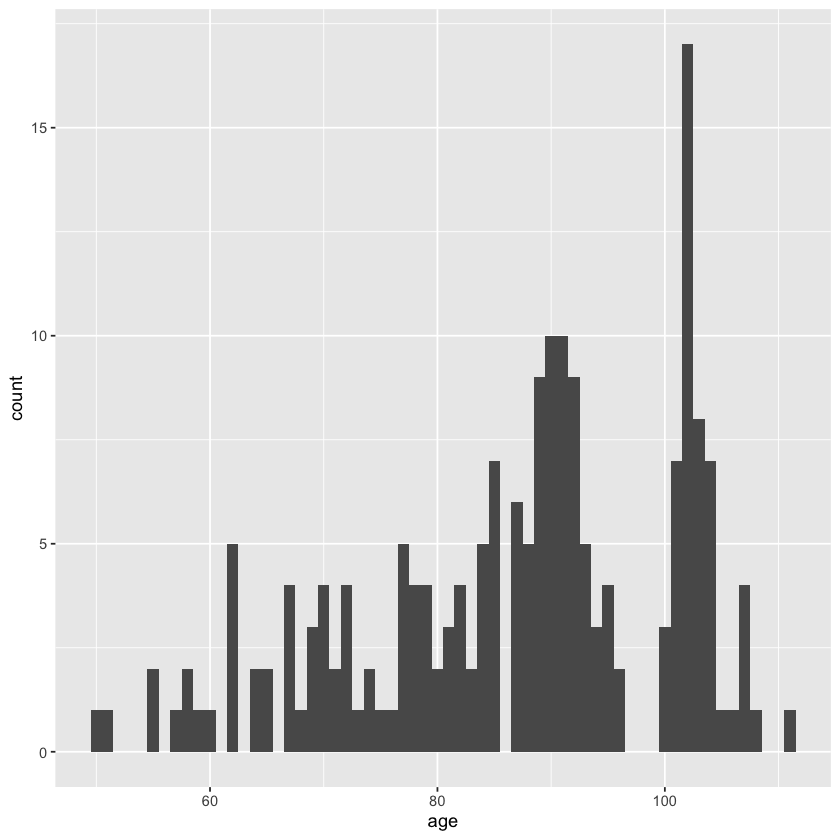

In [236]:
ggplot(metadata, aes(x = age, group = GROUP)) + geom_histogram(aes(group = GROUP), binwidth =1)

In [75]:
test_KSD_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    CHC_idx <- which(protein_metadata$GROUP == "CHC")
    #print(length(CHC_idx))
    #print(table(protein_metadata$GROUP))
    KSD_age <- do.call(rbind, lapply(seq(100, 80, -1), function(age){
        idx_ND_in10y <- which((protein_metadata$age >= (age-10)) & (protein_metadata$age < age))
        KSD <- do.call(rbind, lapply(1:1000, function(i){
            idx_CHC_in10y <- sample(CHC_idx, size = length(idx_ND_in10y), replace = FALSE)
            dist <- as.numeric(ks.test(protein_metadata[idx_ND_in10y,]$intens, 
                                      protein_metadata[idx_CHC_in10y,]$intens, exact = FALSE)$statistic)
            mean_age <- mean(protein_metadata[idx_CHC_in10y,]$age)
            return(list(dist = dist, mean_age = mean_age))
        })) %>% apply(., 2, as.numeric) %>% as.data.frame(colnames = c("dist", "mean_age"))
        
        #print(class(KSD$dist))
        #print(head(KSD))
        return(list(age, length(idx_ND_in10y), mean(protein_metadata[idx_ND_in10y,]$age), mean(KSD$mean_age), sd(KSD$mean_age), 
                    mean(KSD$dist), sd(KSD$dist)))
    })) %>% apply(., 2, as.numeric) %>% as.data.frame()
    colnames(KSD_age) <-  c("age", "num_ND", "ND_age", "CHC_age", "CHC_age_sd", "mean_dist", "mean_dist_sd")
    KSD_age$protein <- rownames(protein_intensity_combat)[index]
    
    return(KSD_age)
}

In [84]:
res <- test_mean_diff_for_aging_protective_proteins(lm_index[1])

In [85]:
res

age,num_ND,mean_diff,protein
<dbl>,<dbl>,<dbl>,<chr>
100,17,0.005114809,SLC12A2
99,20,0.010707608,SLC12A2
98,20,0.010707608,SLC12A2
97,24,0.159020789,SLC12A2
96,23,0.203690760,SLC12A2
95,23,0.172987914,SLC12A2
94,24,0.252376733,SLC12A2
93,23,0.331808838,SLC12A2
92,20,0.370121190,SLC12A2


In [106]:
length(lm_index[cen_sig_idx])
length(lm_index[-cen_sig_idx])

[1] 108

[1] 66

In [46]:
system.time(
    KSD_age_per_protein_NScen66 <- mclapply(lm_index[-cen_sig_idx], test_KSD_for_aging_protective_proteins, 
                                           mc.cores = detectCores() - 2)
)

    user   system  elapsed 
1573.666   25.435  193.093 

In [47]:
length(KSD_age_per_protein_cen108)
length(KSD_age_per_protein_NScen66)

[1] 108

[1] 66

In [48]:
save(KSD_age_per_protein_NScen66, 
     file = "100_plus_results/Sig_results_from_analysis/KSD_age_per_protein_NScen66.Rdata")


In [51]:
Average_KSD_across_108proteins_perAge <- KSD_age_per_protein_cen108[[1]][c("age", "ND_age")]

In [63]:
temp_df <- NULL
for(i in 1:length(KSD_age_per_protein_NScen66)){
    temp_df <- cbind(temp_df, KSD_age_per_protein_NScen66[[i]]$mean_dist)
}

In [67]:
Average_KSD_across_108proteins_perAge$mean_mean_dist_NS66 <- apply(temp_df, 1, median)

In [74]:
Average_KSD_across_108proteins_perAge[which.min(Average_KSD_across_108proteins_perAge$mean_mean_dist), ]
Average_KSD_across_108proteins_perAge[which.min(Average_KSD_across_108proteins_perAge$mean_mean_dist_NS66), ]

,age,ND_age,mean_mean_dist,mean_mean_dist_NS66
,<dbl>,<dbl>,<dbl>,<dbl>
8,93,89,0.2263696,0.2441957


,age,ND_age,mean_mean_dist,mean_mean_dist_NS66
,<dbl>,<dbl>,<dbl>,<dbl>
4,97,90.91667,0.2294792,0.2310833


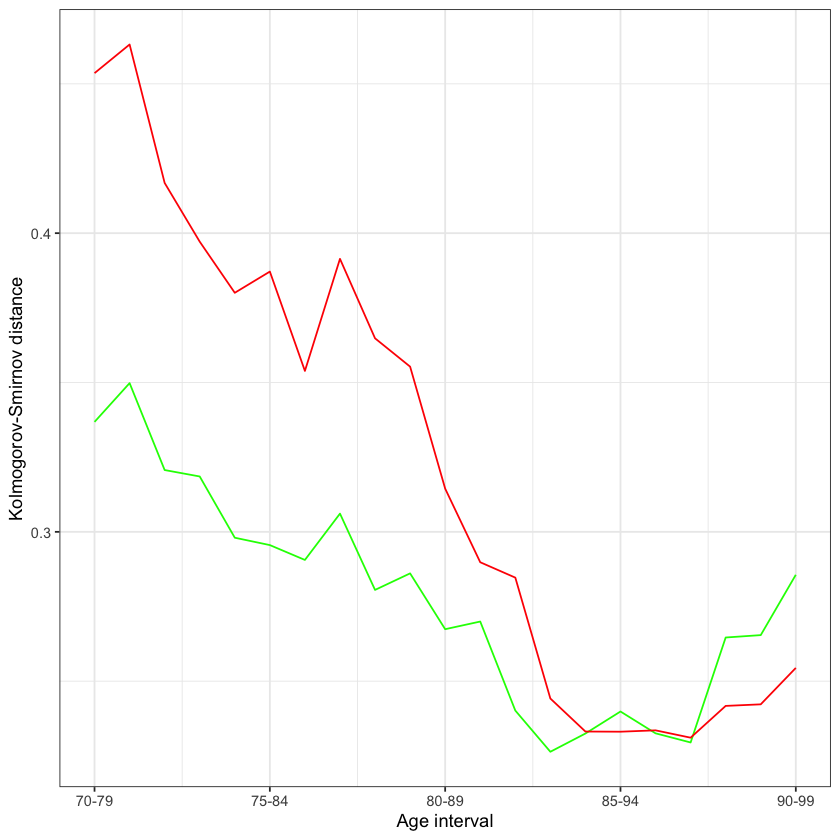

In [73]:
ggplot(Average_KSD_across_108proteins_perAge) + 
    geom_line(aes(x = age, y = mean_mean_dist), color = "green") +
    geom_line(aes(x = age, y = mean_mean_dist_NS66), color = "red") +
    scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
                                                                 "75-84",
                                                                 "80-89",
                                                                 "85-94",
                                                                 "90-99")) +
    xlab("Age interval") + 
    ylab("Kolmogorov-Smirnov distance") +
    theme_bw()

In [109]:
KSD_age_per_protein_all <- do.call(rbind, KSD_age_per_protein) %>% as.data.frame(stringsAsFactors = FALSE)

In [110]:
length(unique((KSD_age_per_protein_all$protein)))

[1] 66

In [111]:
setdiff(aging_protective_test_sig108$protein, unique((KSD_age_per_protein_all$protein)))

[1] "CARNS1"                             "MAP1B"                             
  [3] "IRGQ"                               "SHANK2"                            
  [5] "HADHA"                              "RPS6KA2;RPS6KA3"                   
  [7] "CIT"                                "RPS3"                              
  [9] "TPD52L1"                            "RALA"                              
 [11] "NEFM"                               "PTGES2"                            
 [13] "RRAGC;RRAGD"                        "CNP"                               
 [15] "GSTK1"                              "PDPK1;PDPK2P"                      
 [17] "ANXA11"                             "CACNA1E"                           
 [19] "RPSA"                               "DYNC1I1"                           
 [21] "CCT3"                               "SCN2A"                             
 [23] "INA"                                "ALCAM"                             
 [25] "NCDN"                               "CCT6A"                             
 [27] "SNX9"                               "TUBB3;TUBB4A;TUBB4B"               
 [29] "TUBB"                               "MOG"                               
 [31] "H1FX"                               "NEFL"                              
 [33] "PNMA8B"                             "RAB11A;RAB11B"                     
 [35] "CNTN1"                              "CSDE1"                             
 [37] "STX5"                               "MAP1A;MAP1B"                       
 [39] "TUBB4A;TUBB4B;TUBB8"                "AK3"                               
 [41] "AMPD2"                              "SIRT2"                             
 [43] "SLC44A1"                            "CD9"                               
 [45] "PLEKHB1"                            "C2;CFB"                            
 [47] "RPS16"                              "PTK2B"                             
 [49] "LRRC4B"                             "USP7"                              
 [51] "GNA13"                              "MAG"                               
 [53] "PIP4K2A;PIP4K2B"                    "PDIA6"                             
 [55] "TPBG"                               "NDUFAF4"                           
 [57] "PDE1A;PDE1C"                        "ABLIM1"                            
 [59] "MCAM"                               "PNCK"                              
 [61] "CSNK2A1;CSNK2A3"                    "AP3B1"                             
 [63] "RPS6KA2"                            "USP11"                             
 [65] "IGSF21"                             "TUBB4A"                            
 [67] "PSD3"                               "SHMT2"                             
 [69] "CDK1"                               "LZTS1"                             
 [71] "GGA3"                               "NUMA1"                             
 [73] "LGALS3BP"                           "OGFRL1"                            
 [75] "SNX5"                               "RHOG"                              
 [77] "TUBB3;TUBB6"                        "PON2"                              
 [79] "INA;NEFH;NEFL;NEFM;VIM"             "PCSK1"                             
 [81] "MAP3K5"                             "ENPP6"                             
 [83] "RIMBP2"                             "UBAP2L"                            
 [85] "CCT6B"                              "FAM169A"                           
 [87] "NAP1L1"                             "RPS13"                             
 [89] "RUFY3"                              "SSB"                               
 [91] "DIP2A;DIP2C"                        "GLTP"                              
 [93] "ILF2"                               "RAP1A;RAP1B"                       
 [95] "WASH2P;WASH3P;WASH4P;WASH6P;WASHC1" "CAND1;CAND2"                       
 [97] "ITGB4"                              "ANLN"                              
 [99] "RPL31"                              "WRN"                               
[1

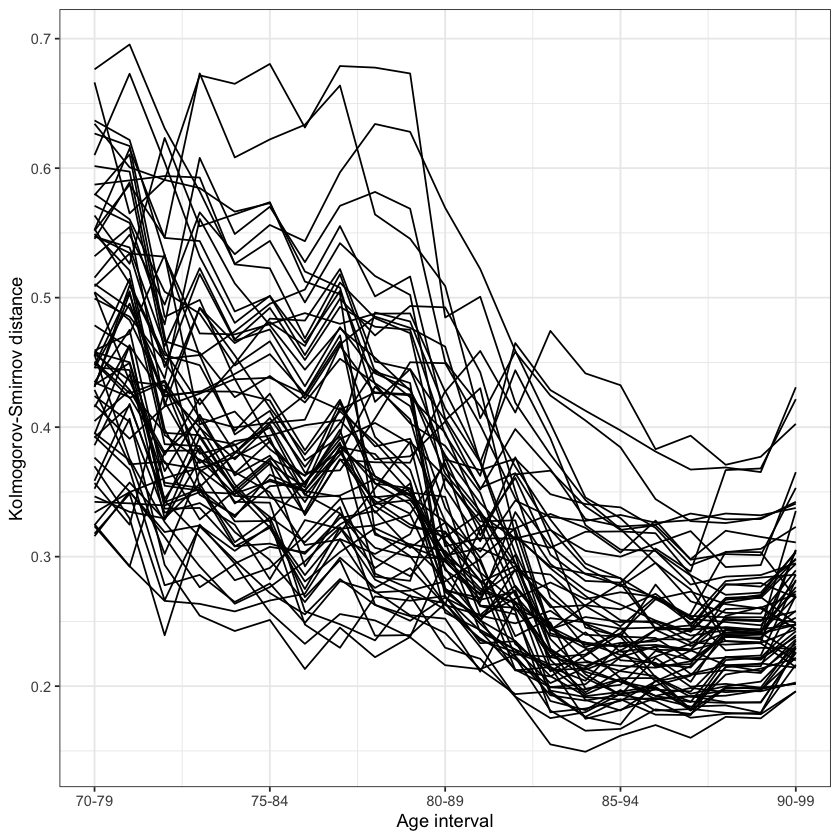

In [112]:
ggplot(KSD_age_per_protein_all, aes(x = as.numeric(age), y = as.numeric(mean_dist), group = as.factor(protein))) + 
    geom_line() +
    scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
                                                                 "75-84",
                                                                 "80-89",
                                                                 "85-94",
                                                                 "90-99")) +
    xlab("Age interval") + 
    ylab("Kolmogorov-Smirnov distance") +
    theme_bw()

In [38]:
test_mean_diff_for_aging_protective_proteins <- function(index){
    intens <- protein_intensity_combat[index,]
    protein_metadata <- cbind(metadata, intens)
    protein_metadata <- subset(protein_metadata, GROUP != "AD")
    protein_metadata$intens <- scale(protein_metadata$intens)
    
    CHC_idx <- which(protein_metadata$GROUP == "CHC")
    
    mean_CHC <- mean(protein_metadata[CHC_idx,]$intens)
    
    KSD_age <- do.call(rbind, lapply(seq(100, 80, -1), function(age){
        idx_ND_in10y <- which((protein_metadata$age >= (age-10)) & (protein_metadata$age < age))
        mean_ND <- mean(protein_metadata[idx_ND_in10y,]$intens)
        mean_diff <- abs(mean_CHC-mean_ND)
        #print(class(KSD$dist))
        #print(head(KSD))
        return(list(age, length(idx_ND_in10y), mean(protein_metadata[idx_ND_in10y,]$age), mean_diff))
    })) %>% apply(., 2, as.numeric) %>% as.data.frame()
    colnames(KSD_age) <-  c("age", "num_ND", "ND_age", "mean_diff")
    KSD_age$protein <- rownames(protein_intensity_combat)[index]
    
    return(KSD_age)
}

In [39]:
meanDiff_age_per_protein <- mclapply(lm_index, test_mean_diff_for_aging_protective_proteins, 
                                     mc.cores = detectCores() - 2)

In [40]:
length(meanDiff_age_per_protein)

[1] 174

In [41]:
meanDiff_age_per_protein[[1]]

age,num_ND,ND_age,mean_diff,protein
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
100,17,92.17647,0.004933839,SLC12A2
99,20,91.70000,0.010328755,SLC12A2
98,20,91.70000,0.010328755,SLC12A2
97,24,90.91667,0.153394374,SLC12A2
96,23,90.69565,0.196483849,SLC12A2
95,23,89.82609,0.166867320,SLC12A2
94,24,89.58333,0.243447232,SLC12A2
93,23,89.00000,0.320068900,SLC12A2
92,20,87.55000,0.357025699,SLC12A2


In [42]:
protein <- NULL
idx <- NULL
mean_age <- NULL
mean_age_ND <- NULL
#mean_age_CHC <- NULL

In [43]:
for(i in 1:length(meanDiff_age_per_protein)){
    temp_df <- as.data.frame(meanDiff_age_per_protein[[i]], stringsAsFactors = FALSE)
    protein <- c(protein, unique(temp_df$protein))
    min_idx <- which.min(as.numeric(temp_df$mean_diff))
    idx <- c(idx, min_idx)
    mean_age <- c(mean_age, as.numeric(temp_df[min_idx, ]$age))
    mean_age_ND <- c(mean_age_ND, as.numeric(temp_df[min_idx, ]$ND_age))
    #mean_age_CHC <- c(mean_age_CHC, as.numeric(temp_df[min_idx, ]$CHC_age))
}

In [44]:
age_diff <- data.frame(protein = protein, index = idx, end_age = mean_age, ND_age = mean_age_ND)

In [45]:
age_diff$CHC_age <- mean(subset(metadata, GROUP == "CHC")$age)

In [46]:
age_diff$younger <- age_diff$CHC_age - age_diff$ND_age

In [47]:
age_diff$cen_specific <- "no"
age_diff[cen_sig_idx, ]$cen_specific <- "yes"

In [48]:
age_diff

protein,index,end_age,ND_age,CHC_age,younger,cen_specific
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SLC12A2,1,100,92.17647,103.0408,10.86435,no
CARNS1,9,92,87.55000,103.0408,15.49082,yes
MAP1B,12,89,83.00000,103.0408,20.04082,yes
SLC16A1,1,100,92.17647,103.0408,10.86435,no
IRGQ,9,92,87.55000,103.0408,15.49082,yes
MTHFD1,6,95,89.82609,103.0408,13.21473,no
HSPA12A,2,99,91.70000,103.0408,11.34082,no
FLOT1,2,99,91.70000,103.0408,11.34082,no
KBTBD11,6,95,89.82609,103.0408,13.21473,no


In [50]:
write.table(age_diff, 
            "100_plus_results/Age_differ_for_174_protein.tsv", 
            sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)

In [157]:
summary(age_diff$younger)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.86   12.12   14.04   16.68   21.76   28.04 

In [289]:
summary(age_diff[cen_sig_idx, ]$younger)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.86   13.46   18.17   19.11   23.90   28.04 

In [290]:
summary(age_diff[cen_sig_idx, ]$end_age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  80.00   83.75   90.00   89.12   94.00  100.00 

In [292]:
summary(age_diff[-cen_sig_idx, ]$younger)
summary(age_diff[-cen_sig_idx, ]$end_age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.86   10.86   11.34   12.69   13.21   22.54 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  86.00   95.00   99.00   96.89  100.00  100.00 

In [164]:
mu <- ddply(age_diff, "cen_specific", summarise, grp.mean=mean(younger))
head(mu)

,cen_specific,grp.mean
,<chr>,<dbl>
1,no,12.68979
2,yes,19.11306


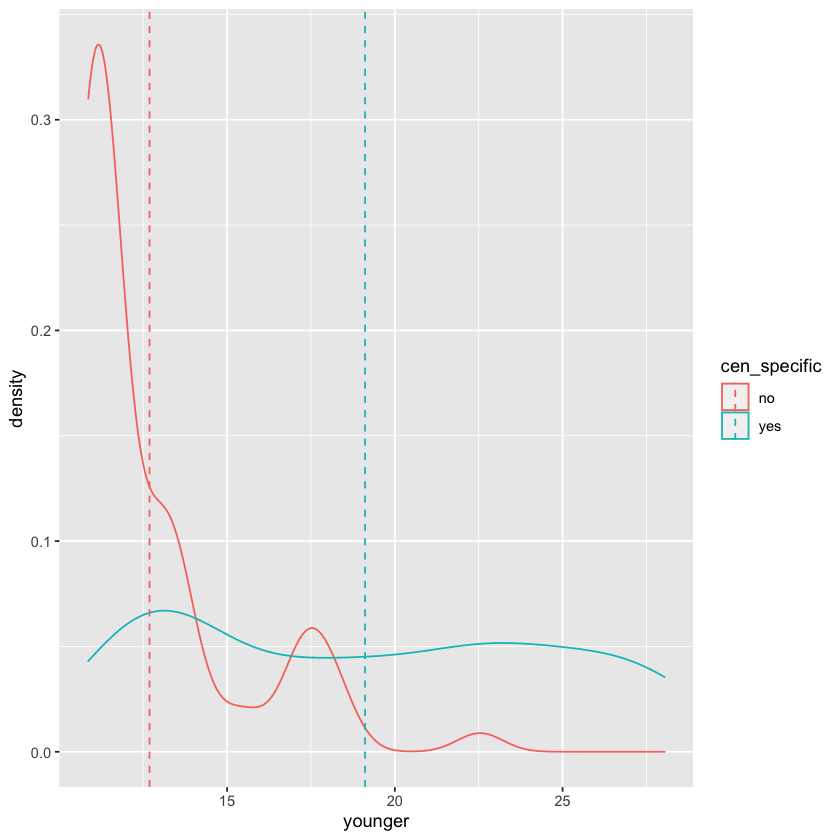

In [165]:
ggplot(age_diff, aes(x = younger, color = cen_specific)) +
    geom_density()+
    geom_vline(data=mu, aes(xintercept = grp.mean, color = cen_specific),
             linetype="dashed")

In [172]:
Average_meanDiff_across_proteins_perAge <- meanDiff_age_per_protein[[1]][c("age", "num_ND", "ND_age")]

In [173]:
temp_df <- NULL
for(i in cen_sig_idx){
    temp_df <- cbind(temp_df, meanDiff_age_per_protein[[i]]$mean_diff)
}

Average_meanDiff_across_proteins_perAge$mean_meanDiff_108 <- rowMeans(temp_df)
Average_meanDiff_across_proteins_perAge$sd_meanDiff_108 <- rowSds(temp_df)

In [174]:
temp_df <- NULL
for(i in setdiff(1:length(meanDiff_age_per_protein), cen_sig_idx)){
    temp_df <- cbind(temp_df, meanDiff_age_per_protein[[i]]$mean_diff)
}

Average_meanDiff_across_proteins_perAge$mean_meanDiff_66 <- rowMeans(temp_df)
Average_meanDiff_across_proteins_perAge$sd_meanDiff_66 <- rowSds(temp_df)

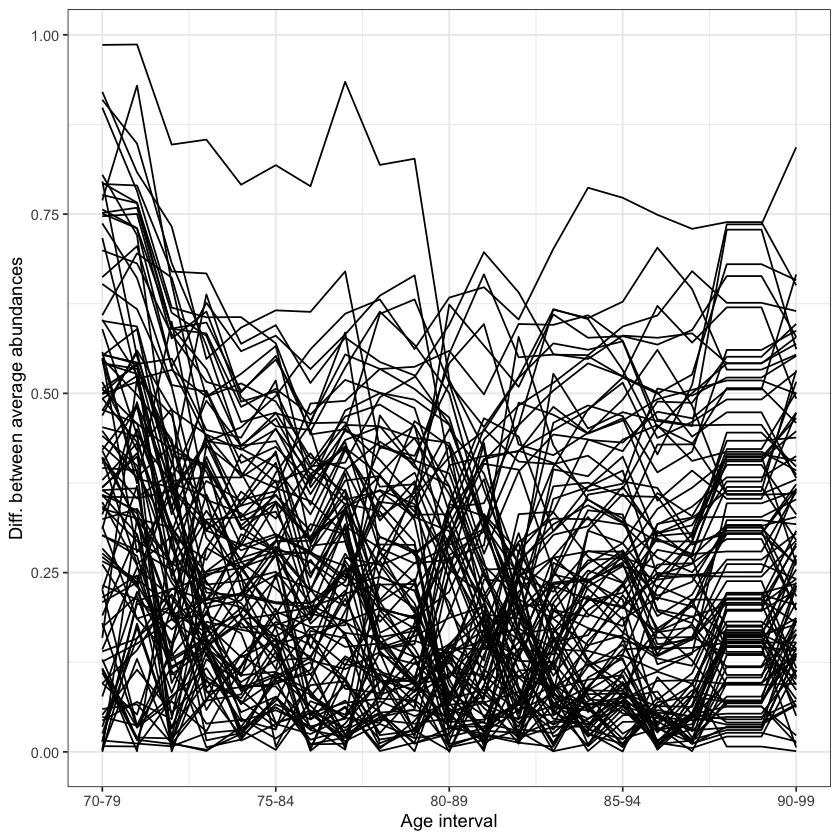

In [287]:
meanDiff_age_per_protein_cen66_all <- do.call(rbind, meanDiff_age_per_protein[cen_sig_idx]) %>% as.data.frame(stringsAsFactors = FALSE)
ggplot(meanDiff_age_per_protein_cen66_all, aes(x = age, y = mean_diff, group = protein)) + 
    geom_line() +
    scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
                                                                 "75-84",
                                                                 "80-89",
                                                                 "85-94",
                                                                 "90-99")) +
    xlab("Age interval") + 
    ylab("Diff. between average abundances") +
    theme_bw()

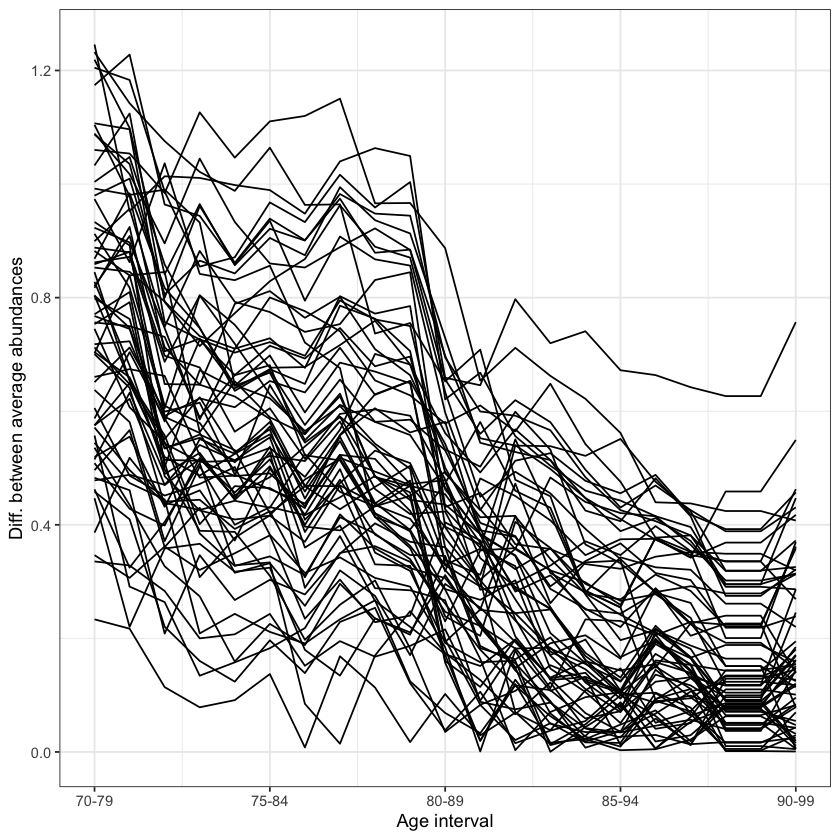

In [245]:
meanDiff_age_per_protein_cen66_all <- do.call(rbind, meanDiff_age_per_protein[-cen_sig_idx]) %>% as.data.frame(stringsAsFactors = FALSE)
ggplot(meanDiff_age_per_protein_cen66_all, aes(x = age, y = mean_diff, group = protein)) + 
    geom_line() +
    scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
                                                                 "75-84",
                                                                 "80-89",
                                                                 "85-94",
                                                                 "90-99")) +
    xlab("Age interval") + 
    ylab("Diff. between average abundances") +
    theme_bw()

In [216]:
Average_meanDiff_across_proteins_perAge

age,num_ND,ND_age,mean_meanDiff_108,sd_meanDiff_108,mean_meanDiff_66,sd_meanDiff_66
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100,17,92.17647,0.2871285,0.1811518,0.1952738,0.1561771
99,20,91.70000,0.2734220,0.1850541,0.1711554,0.1317360
98,20,91.70000,0.2734220,0.1850541,0.1711554,0.1317360
97,24,90.91667,0.2254466,0.1796091,0.2034004,0.1391070
96,23,90.69565,0.2206854,0.1833447,0.2254105,0.1488960
95,23,89.82609,0.2395202,0.1743301,0.2089157,0.1624696
94,24,89.58333,0.2303092,0.1773908,0.2312182,0.1706718
93,23,89.00000,0.2194607,0.1733671,0.2688931,0.1881233
92,20,87.55000,0.2087202,0.1580562,0.3129863,0.1855208


In [217]:
mean(subset(metadata, GROUP == "CHC")$age) - 91.70000

[1] 11.34082

In [218]:
mean(subset(metadata, GROUP == "CHC")$age) - 87.55000

[1] 15.49082

In [241]:
plot_p108 <- Average_meanDiff_across_proteins_perAge[c("age", "num_ND", "ND_age", 
                                                       "mean_meanDiff_108", "sd_meanDiff_108")]
colnames(plot_p108) <- c("age", "num_ND", "ND_age", "mean", "sd")
plot_p108$cen_spe <- "yes"

plot_p66 <- Average_meanDiff_across_proteins_perAge[c("age", "num_ND", "ND_age", 
                                                       "mean_meanDiff_66", "sd_meanDiff_66")]
colnames(plot_p66) <- c("age", "num_ND", "ND_age", "mean", "sd")
plot_p66$cen_spe <- "no"

In [242]:
plot_p2groups <- rbind(plot_p108, plot_p66)

Warning message:
“position_dodge requires non-overlapping x intervals”

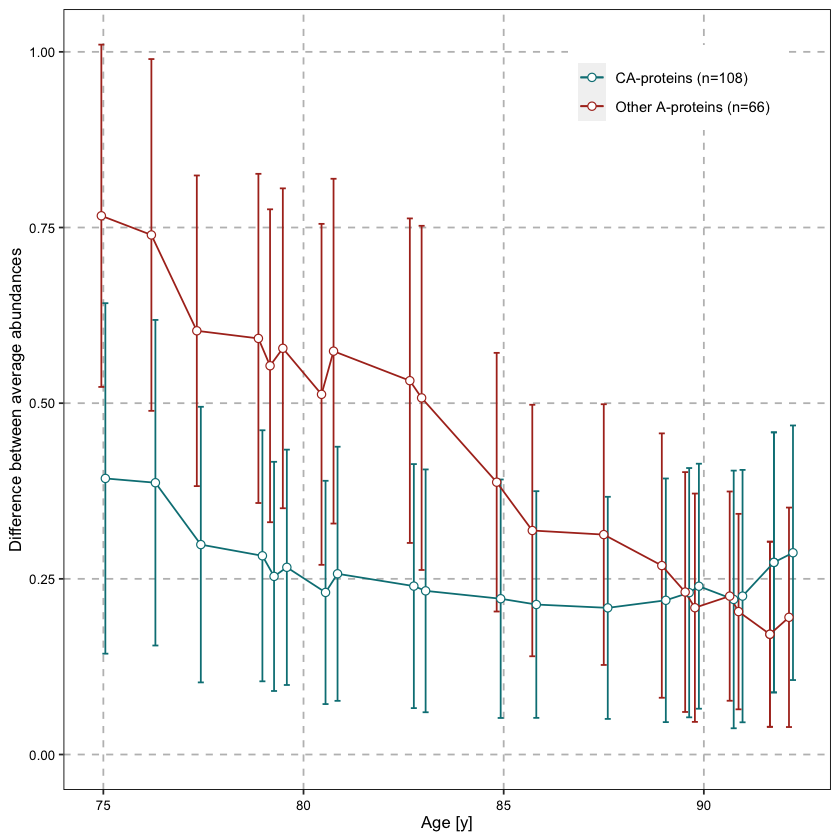

In [284]:
pd <- position_dodge(0.2)
CA_protein_age_estimation <- ggplot(plot_p2groups, mapping = aes(x = ND_age, y = mean, color = cen_spe, group=cen_spe)) + 
    geom_errorbar(aes(ymin=mean-sd, ymax=mean+sd), width=.3, position=pd) +
    geom_line(position=pd) +
    geom_point(position=pd, size=2, shape=21, fill="white") + # 21 is filled circle
    xlab("Age [y]") + 
    ylab("Difference between average abundances") +
    scale_colour_hue(name=NULL,    # Legend label, use darker colors
                     breaks=c("yes", "no"),
                     labels=c("CA-proteins (n=108)", "Other A-proteins (n=66)"),
                     l=40) +                    # Use darker colors, lightness=40
    expand_limits(y=0) +                        # Expand y range
    #scale_y_continuous(breaks=0:20*4) +         # Set tick every 4
    theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
          panel.border = element_rect(color = "black", size = 0.5, fill=NA),       # Border around plotting area.
                                               # fill argument should be NA
            
          legend.position=c(0.8,0.9),
          
          legend.title=element_blank(),
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5, size = 9),
          axis.title.x = element_text(color = "black", size = 10),
          axis.title.y = element_text(color = "black", size = 10),
          
          axis.text.x = element_text(size = 8, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black"),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                        colour = "black")
         )

CA_protein_age_estimation

In [286]:
save_plot("100_plus_plots/proteomics/CA_protein_age_estimation_plot.pdf", 
          CA_protein_age_estimation, base_height = 4, base_width = 5)

Warning message:
“position_dodge requires non-overlapping x intervals”

In [34]:
median(subset(age_diff, cen_specific == "no")$estimate_age)

[1] 91.7

In [20]:
age_diff <- read.table("100_plus_results/Age_differ_for_174_protein.tsv", header = TRUE)

In [21]:
age_diff$estimate_age <- age_diff$CHC_age - age_diff$younger
age_diff$cen_specific <- factor(age_diff$cen_specific, levels = c("yes", "no"))

In [55]:
CA_protein_age_estimation_distribution <- ggplot(age_diff, aes(x = estimate_age, group = cen_specific)) +
    geom_histogram(aes(y=..count.., fill = cen_specific, color = cen_specific), 
                   position="dodge",
                   binwidth = 0.6, 
                   alpha=0.7)+
    geom_density(aes(y = after_stat(count), fill = cen_specific, color = cen_specific), 
                 adjust = 0.5, alpha = 0.7) + 
    
    geom_vline(xintercept = 84.875, linetype="dashed", color = "#F7931E", alpha = 0.7, size=1) +
    geom_vline(xintercept = 91.700, linetype="dashed", color = "#0071BC", alpha = 0.7, size=1) +
    
    xlab("Estimated age of centenarians [y]") + 
    ylab("Number of proteins") + 

    scale_colour_manual(name=NULL,    # Legend label, use darker colors
                        breaks=c("yes", "no"),
                        values=c("#F7931E", "#0071BC"),
                        labels=c("Cen Age-proteins (n=108)", "Other Age-proteins (n=66)")) +

    scale_fill_manual(name=NULL,    # Legend label, use darker colors
                      breaks=c("yes", "no"),
                      values=c("#F7931E", "#0071BC"),
                      labels=c("Cen Age-proteins (n=108)", "Other Age-proteins (n=66)")) +

    theme(panel.background = element_rect(fill = "white"),   # Background of plotting area
          panel.border = element_rect(color = "black", size = 0.5, fill=NA),       # Border around plotting area.
                                               # fill argument should be NA
            
          legend.position=c(0.25,0.85),
          
          legend.title=element_blank(),
  
          panel.grid.major.x = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Vertical major grid lines
          panel.grid.major.y = element_line(size = 0.5, linetype = 'dashed',
                                color = "gray"), # Horizontal major grid lines
          panel.grid.minor.x = element_line(), # Vertical minor grid lines
          panel.grid.minor.y = element_line(),  # Vertical major grid lines
        
          plot.title = element_text(hjust = 0.5, size = 9),
          axis.title.x = element_text(color = "black", size = 10),
          axis.title.y = element_text(color = "black", size = 10),
          
          axis.text.x = element_text(size = 8, color = "black", 
                                     vjust = 0.5, hjust = 0.5),
          axis.text.y = element_text(size = 8, color = "black"),
          
          #axis.line = element_line(size = 0.5, linetype = "solid",
          #                        colour = "black")
         )

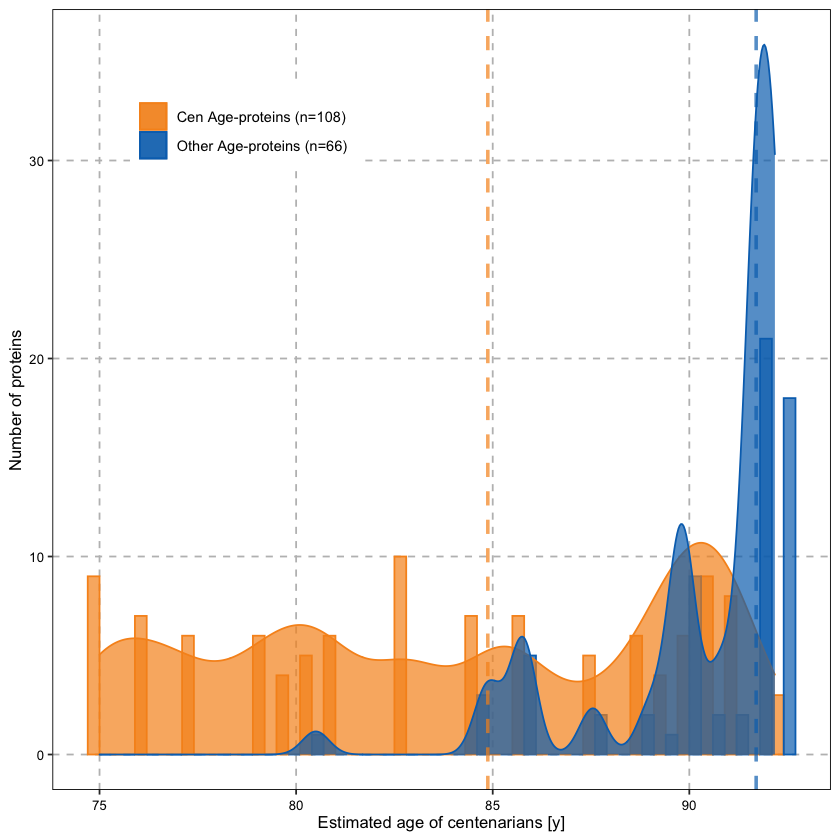

In [56]:
CA_protein_age_estimation_distribution

In [57]:
save_plot("100_plus_plots/proteomics/CA_protein_age_estimation_distribution_and_bar_plot-20231113.pdf", 
          CA_protein_age_estimation_distribution, base_height = 4, base_width = 5)

In [113]:
protein <- NULL
idx <- NULL
mean_age <- NULL
mean_age_ND <- NULL
mean_age_CHC <- NULL

In [114]:
for(i in 1:length(KSD_age_per_protein)){
    temp_df <- as.data.frame(KSD_age_per_protein[[i]], stringsAsFactors = FALSE)
    protein <- c(protein, unique(temp_df$protein))
    min_idx <- which.min(as.numeric(temp_df$mean_dist))
    idx <- c(idx, min_idx)
    mean_age <- c(mean_age, as.numeric(temp_df[min_idx, ]$age))
    mean_age_ND <- c(mean_age_ND, as.numeric(temp_df[min_idx, ]$ND_age))
    mean_age_CHC <- c(mean_age_CHC, as.numeric(temp_df[min_idx, ]$CHC_age))
}

In [115]:
age_diff <- data.frame(protein = protein, index = idx, end_age = mean_age, ND_age = mean_age_ND, CHC_age = mean_age_CHC)

In [116]:
age_diff$younger <- age_diff$CHC_age - age_diff$ND_age

In [117]:
summary(age_diff$younger)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.85   12.12   12.34   13.24   13.46   23.85 

In [118]:
mean(age_diff$end_age)
sd(age_diff$end_age)

[1] 95.33333

[1] 3.00427

In [119]:
age_diff

protein,index,end_age,ND_age,CHC_age,younger
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
SLC12A2,4,97,90.91667,103.0423,12.12562
SLC16A1,4,97,90.91667,103.0453,12.12867
MTHFD1,6,95,89.82609,103.0354,13.20935
HSPA12A,7,94,89.58333,103.0415,13.45813
FLOT1,1,100,92.17647,103.0306,10.85412
KBTBD11,4,97,90.91667,103.0272,12.11058
ATP1A2,10,91,85.76471,103.0104,17.24565
AMPH,3,98,91.70000,103.0343,11.33430
ATP1A1;ATP1A3,6,95,89.82609,103.0423,13.21617


In [120]:
table(idx)
table(mean_age)

idx
 1  2  3  4  5  6  7  8  9 10 11 15 17 
 1  6  7 17  5  6  9  7  1  4  1  1  1 

mean_age
 84  86  90  91  92  93  94  95  96  97  98  99 100 
  1   1   1   4   1   7   9   6   5  17   7   6   1 

In [121]:
table(idx)
table(mean_age)

idx
 1  2  3  4  5  6  7  8  9 10 11 15 17 
 1  6  7 17  5  6  9  7  1  4  1  1  1 

mean_age
 84  86  90  91  92  93  94  95  96  97  98  99 100 
  1   1   1   4   1   7   9   6   5  17   7   6   1 

In [122]:
mean(mean_age)
sd(mean_age)

[1] 95.33333

[1] 3.00427

In [227]:
breaks = seq(from = 0.025, to = 0.975, by = 0.025)
quantile <- qnorm(breaks, mean = 0, sd = 1, lower.tail = TRUE, log.p = FALSE)

In [228]:
temp_df <- as.matrix(Average_meanDiff_across_proteins_perAge["sd_meanDiff_108"]) %*% as.vector(quantile)

protein108_CI_df <- apply(temp_df, 2, function(x){
    x + Average_meanDiff_across_proteins_perAge$mean_meanDiff_108
}) %>% as.data.frame()
colnames(protein108_CI_df) <- paste("CI_", breaks, sep = "")

In [229]:
protein108_CI_df <- cbind(Average_meanDiff_across_proteins_perAge[c("ND_age")], protein108_CI_df)

In [230]:
protein108_CI_df

ND_age,CI_0.025,CI_0.05,CI_0.075,CI_0.1,CI_0.125,CI_0.15,CI_0.175,CI_0.2,CI_0.225,⋯,CI_0.75,CI_0.775,CI_0.8,CI_0.825,CI_0.85,CI_0.875,CI_0.9,CI_0.925,CI_0.95,CI_0.975
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
92.17647,-0.06792250,-0.010839689,0.026354793,0.054973140,0.078740654,0.09937674,0.11782599,0.13466732,0.15028373,⋯,0.4093136,0.4239733,0.4395898,0.4564311,0.4748803,0.4955164,0.5192839,0.5479023,0.5850968,0.6421796
91.70000,-0.08927734,-0.030964885,0.007030819,0.036265646,0.060545146,0.08162577,0.10047243,0.11767655,0.13362936,⋯,0.3982391,0.4132146,0.4291674,0.4463716,0.4652182,0.4862989,0.5105784,0.5398132,0.5778089,0.6361213
91.70000,-0.08927734,-0.030964885,0.007030819,0.036265646,0.060545146,0.08162577,0.10047243,0.11767655,0.13362936,⋯,0.3982391,0.4132146,0.4291674,0.4463716,0.4652182,0.4862989,0.5105784,0.5398132,0.5778089,0.6361213
90.91667,-0.12658075,-0.069984062,-0.033106334,-0.004731705,0.018833401,0.03929375,0.05758588,0.07428379,0.08976720,⋯,0.3465911,0.3611260,0.3766094,0.3933074,0.4115995,0.4320598,0.4556249,0.4839996,0.5208773,0.5774740
90.69565,-0.13866358,-0.080889777,-0.043245054,-0.014280279,0.009774943,0.03066083,0.04933341,0.06637860,0.08218405,⋯,0.3443495,0.3591867,0.3749921,0.3920373,0.4107099,0.4315958,0.4556510,0.4846158,0.5222605,0.5800343
89.82609,-0.10216053,-0.047227302,-0.011433466,0.016107191,0.038979684,0.05883867,0.07659317,0.09280030,0.10782864,⋯,0.3571041,0.3712118,0.3862402,0.4024473,0.4202018,0.4400608,0.4629333,0.4904739,0.5262678,0.5812010
89.58333,-0.11737031,-0.061472639,-0.025050380,0.002973799,0.026247858,0.04645551,0.06452171,0.08101339,0.09630557,⋯,0.3499575,0.3643129,0.3796051,0.3960968,0.4141630,0.4343706,0.4576447,0.4856689,0.5220911,0.5779888
89.00000,-0.12033268,-0.065702901,-0.030106785,-0.002718260,0.020027888,0.03977718,0.05743360,0.07355121,0.08849653,⋯,0.3363950,0.3504248,0.3653701,0.3814878,0.3991442,0.4188935,0.4416396,0.4690281,0.5046243,0.5592540
87.55000,-0.10106421,-0.051259069,-0.018806629,0.006163075,0.026900393,0.04490552,0.06100261,0.07569679,0.08932222,⋯,0.3153275,0.3281183,0.3417437,0.3564379,0.3725350,0.3905401,0.4112774,0.4362471,0.4686996,0.5185047


In [231]:
temp_df <- as.matrix(Average_meanDiff_across_proteins_perAge["sd_meanDiff_66"]) %*% as.vector(quantile)

protein66_CI_df <- apply(temp_df, 2, function(x){
    x + Average_meanDiff_across_proteins_perAge$mean_meanDiff_66
}) %>% as.data.frame()
colnames(protein66_CI_df) <- paste("CI_", breaks, sep = "")

In [232]:
protein66_CI_df <- cbind(Average_meanDiff_across_proteins_perAge[c("ND_age")], protein66_CI_df)

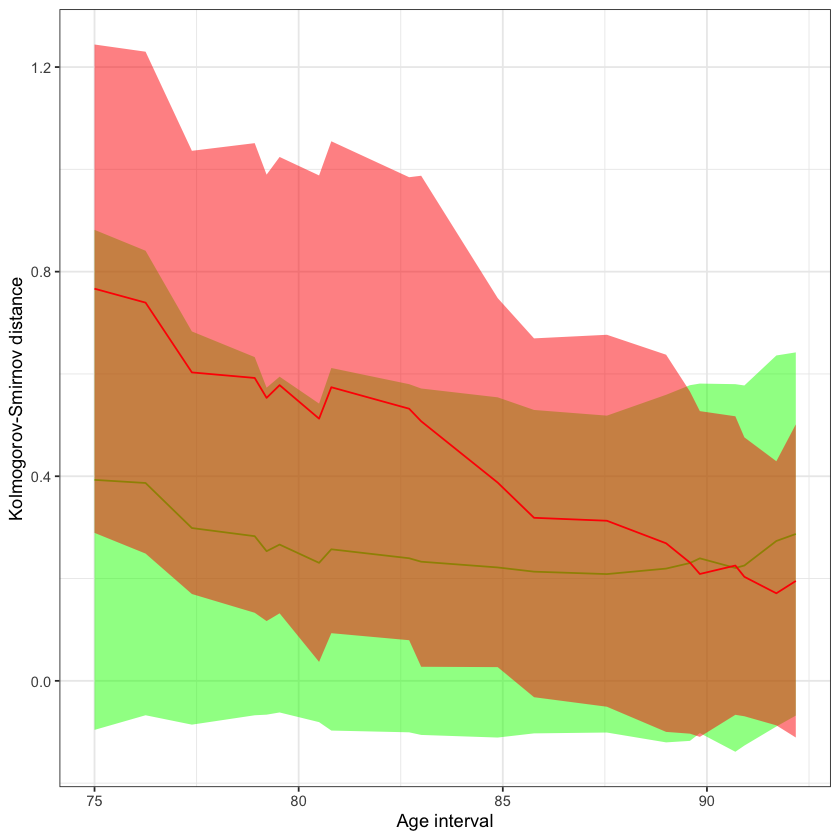

In [235]:
ggplot(Average_meanDiff_across_proteins_perAge, mapping = aes(x = ND_age)) + 
    geom_line(Average_meanDiff_across_proteins_perAge, mapping = aes(x = ND_age, y = mean_meanDiff_108), color = color_ND) +
    geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.025,ymax=CI_0.975), fill=color_ND, alpha=0.5) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.05,ymax=CI_0.95), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.075,ymax=CI_0.925), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.1,ymax=CI_0.9), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.125,ymax=CI_0.875), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.15,ymax=CI_0.85), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.175,ymax=CI_0.825), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.2,ymax=CI_0.8), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.225,ymax=CI_0.775), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.25,ymax=CI_0.75), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.275,ymax=CI_0.725), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.3,ymax=CI_0.7), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.325,ymax=CI_0.675), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.35,ymax=CI_0.65), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.375,ymax=CI_0.625), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.4,ymax=CI_0.6), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.425,ymax=CI_0.575), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.45,ymax=CI_0.55), fill=color_ND, alpha=0.05) +
    #geom_ribbon(protein108_CI_df, mapping = aes(ymin=CI_0.475,ymax=CI_0.525), fill=color_ND, alpha=0.05) +
    #geom_line(protein108_CI_df, mapping = aes(y=CI_0.5), col=color_ND, alpha=1, size = 0.5) +

    geom_line(Average_meanDiff_across_proteins_perAge, mapping = aes(x = ND_age, y = mean_meanDiff_66), color = color_AD) +
    geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.025,ymax=CI_0.975), fill=color_AD, alpha=0.5) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.05,ymax=CI_0.95), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.075,ymax=CI_0.925), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.1,ymax=CI_0.9), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.125,ymax=CI_0.875), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.15,ymax=CI_0.85), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.175,ymax=CI_0.825), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.2,ymax=CI_0.8), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.225,ymax=CI_0.775), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.25,ymax=CI_0.75), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.275,ymax=CI_0.725), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.3,ymax=CI_0.7), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.325,ymax=CI_0.675), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.35,ymax=CI_0.65), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.375,ymax=CI_0.625), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.4,ymax=CI_0.6), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.425,ymax=CI_0.575), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.45,ymax=CI_0.55), fill=color_AD, alpha=0.05) +
    #geom_ribbon(protein66_CI_df, mapping = aes(ymin=CI_0.475,ymax=CI_0.525), fill=color_AD, alpha=0.05) +
    #geom_line(protein66_CI_df, mapping = aes(y=CI_0.5), col=color_AD, alpha=1, size = 0.5) +
    #scale_x_continuous(breaks=c(80, 85, 90, 95, 100), labels = c("70-79", 
    #                                                             "75-84",
    #                                                             "80-89",
    #                                                             "85-94",
    #                                                             "90-99")) +
    xlab("Age interval") + 
    ylab("Kolmogorov-Smirnov distance") +
    theme_bw()